# Transduction Detection Analysis: Two-Method Comparison

This notebook compares two transduction detection methods on the superking dataset:

## Methods
1. **Augmentation method**: Tests augmentation invariance (vertical flip, horizontal flip, color rotation)
2. **Code-based method**: Uses machine learning classifier on program features

## Dataset
- **Source**: BigQuery superking dataset (`trelis-arc.arc.superking`)

## Analysis Goals
1. Download all programs and task_ids from superking dataset
2. Apply both transduction detection methods
3. Compare classification differences and analyze patterns
4. Identify cases where methods disagree and understand why
5. Evaluate correlation and complementary nature of the methods

In [36]:
# Setup project path and imports
from pathlib import Path
import sys
project_root = next((parent for parent in [Path.cwd()] + list(Path.cwd().parents) if (parent / "pyproject.toml").exists()), Path.cwd())
sys.path.append(str(project_root))

import pandas as pd
import numpy as np
from google.cloud import bigquery
from typing import Dict, List, Tuple, Any
import json
from tqdm.auto import tqdm

# Import our transduction detection functions
from llm_python.transduction.augmentation_classifier import detect_transduction_augmentation
from llm_python.transduction.code_based_classifier import classify_transductive_program
from llm_python.utils.arc_tester import ArcTester
from llm_python.utils.task_loader import TaskData
from llm_python.datasets.bigquery_export import load_bigquery_table_as_dataframe

print("✓ All imports successful")
print(f"✓ Project root: {project_root}")

✓ All imports successful
✓ Project root: /home/lewis/code/trelis-arc


In [37]:
# Step 1: Download superking dataset from Google Cloud Storage
from google.cloud import storage
import glob

# GCS bucket and path
gcs_bucket = "trelis-arc"
gcs_prefix = "datasets/superking"
local_download_dir = "/tmp/superking_data"
output_path = "/tmp/superking_analysis.parquet"

print("Downloading superking dataset from Google Cloud Storage...")
print(f"Bucket: gs://{gcs_bucket}/{gcs_prefix}")

# Create local directory
Path(local_download_dir).mkdir(parents=True, exist_ok=True)

try:
    # Initialize GCS client
    storage_client = storage.Client()
    bucket = storage_client.bucket(gcs_bucket)
    
    # List all parquet files in the superking dataset
    blobs = list(bucket.list_blobs(prefix=gcs_prefix))
    parquet_blobs = [blob for blob in blobs if blob.name.endswith('.parquet')]
    
    print(f"✓ Found {len(parquet_blobs)} parquet files in {gcs_prefix}")
    
    # Download all parquet files
    local_files = []
    for blob in parquet_blobs:
        filename = blob.name.split('/')[-1]  # Get just the filename
        local_path = f"{local_download_dir}/{filename}"
        
        print(f"  Downloading {blob.name} -> {local_path}")
        blob.download_to_filename(local_path)
        local_files.append(local_path)
    
    print(f"✓ Downloaded {len(local_files)} files")
    
    # Combine all parquet files into a single DataFrame
    print("Combining parquet files...")
    dataframes = []
    for file_path in local_files:
        df_part = pd.read_parquet(file_path)
        print(f"  {file_path}: {len(df_part):,} rows")
        dataframes.append(df_part)
    
    # Concatenate all dataframes
    raw_data = pd.concat(dataframes, ignore_index=True)
    
    print(f"✓ Combined dataset: {len(raw_data):,} programs")
    print(f"✓ Columns: {list(raw_data.columns)}")
    
    # Save combined dataset to local parquet for analysis
    raw_data.to_parquet(output_path, index=False)
    print(f"✓ Saved combined dataset to: {output_path}")
    
    # Show sample of the data
    print(f"\nFirst few rows:")
    print(raw_data.head())
    
    # Clean up individual downloaded files
    import os
    for file_path in local_files:
        os.remove(file_path)
    os.rmdir(local_download_dir)
    print(f"✓ Cleaned up temporary files")
    
except Exception as e:
    print(f"❌ Error downloading data: {e}")
    raise

Bucket: gs://trelis-arc/datasets/superking
✓ Found 2 parquet files in datasets/superking
✓ Found 2 parquet files in datasets/superking
✓ Downloaded 2 files
Combining parquet files...
  /tmp/superking_data/local_snapshot_506001e34ea54428.parquet: 17 rows
✓ Downloaded 2 files
Combining parquet files...
  /tmp/superking_data/local_snapshot_506001e34ea54428.parquet: 17 rows
  /tmp/superking_data/rollup_snapshot_20250813.parquet: 276,643 rows
  /tmp/superking_data/rollup_snapshot_20250813.parquet: 276,643 rows
✓ Combined dataset: 276,660 programs
✓ Columns: ['task_id', 'reasoning', 'code', 'correct_train_input', 'correct_test_input', 'predicted_train_output', 'predicted_test_output', 'model']
✓ Combined dataset: 276,660 programs
✓ Columns: ['task_id', 'reasoning', 'code', 'correct_train_input', 'correct_test_input', 'predicted_train_output', 'predicted_test_output', 'model']
✓ Saved combined dataset to: /tmp/superking_analysis.parquet

First few rows:
    task_id                            

In [38]:
# Step 2: Examine data structure and prepare for analysis
df = pd.read_parquet(output_path)

print("Dataset Overview:")
print(f"- Total programs: {len(df):,}")
print(f"- Unique tasks: {df['task_id'].nunique():,}")
print(f"- Columns: {list(df.columns)}")
print(f"- Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

# Check what columns we have for task data
print(f"\nColumn details:")
for col in df.columns:
    print(f"- {col}: {df[col].dtype}")
    if col in ['predicted_train_output', 'predicted_test_output']:
        print(f"  Sample value type: {type(df[col].iloc[0])}")

# Look at a sample program
print(f"\nSample program:")
sample_row = df.iloc[0]
print(f"Task ID: {sample_row['task_id']}")
print(f"Code length: {len(sample_row['code'])} characters")
print(f"Code preview:\n{sample_row['code'][:200]}...")

# Check if we have task data or need to load it separately
if 'task_data' in df.columns:
    print("✓ Task data is included in the dataset")
else:
    print("⚠️  Task data not included - we'll need to load it separately")

Dataset Overview:
- Total programs: 276,660
- Unique tasks: 977
- Columns: ['task_id', 'reasoning', 'code', 'correct_train_input', 'correct_test_input', 'predicted_train_output', 'predicted_test_output', 'model']
- Memory usage: 497.2 MB

Column details:
- task_id: object
- reasoning: object
- code: object
- correct_train_input: object
- correct_test_input: object
- predicted_train_output: object
  Sample value type: <class 'numpy.ndarray'>
- predicted_test_output: object
  Sample value type: <class 'numpy.ndarray'>
- model: object

Sample program:
Task ID: 007bbfb7
Code length: 421 characters
Code preview:
def transform(grid):
    n = len(grid)
    new_size = n * 3
    new_grid = [[0 for _ in range(new_size)] for _ in range(new_size)]
    for i in range(n):
        for j in range(n):
            value =...
⚠️  Task data not included - we'll need to load it separately


In [39]:
# Step 3: Load ARC task data using TaskLoader
from llm_python.utils.task_loader import TaskLoader

# Initialize the task loader - this will automatically find and load all ARC data
print("Initializing TaskLoader...")
task_loader = TaskLoader()

print(f"✓ TaskLoader initialized with {len(task_loader.tasks)} tasks available")
print(f"✓ Available subsets: {list(task_loader.subsets.keys())[:10]}...")  # Show first 10

# Check coverage of our dataset
unique_task_ids = set(df['task_id'].unique())
available_tasks = set(task_loader.tasks.keys())
covered_tasks = unique_task_ids.intersection(available_tasks)
missing_tasks = unique_task_ids - available_tasks

print(f"✓ Task coverage: {len(covered_tasks)}/{len(unique_task_ids)} ({100*len(covered_tasks)/len(unique_task_ids):.1f}%)")
if missing_tasks:
    print(f"⚠️  Missing {len(missing_tasks)} tasks: {list(missing_tasks)[:5]}...")

# Filter to only programs with available task data
df_filtered = df[df['task_id'].isin(available_tasks)].copy()
print(f"✓ Filtered to {len(df_filtered)} programs with task data available")

# Helper function to get task data for our analysis
def get_task_data(task_id: str) -> TaskData:
    """Get task data for a given task ID"""
    try:
        return task_loader.get_task(task_id)
    except FileNotFoundError:
        print(f"⚠️  Task {task_id} not found")
        return None

Initializing TaskLoader...
Loading arc-prize-2024...
  Training: 400 tasks
  Evaluation: 400 tasks
  Test: 100 tasks
Loading arc-prize-2025...
  Training: 1000 tasks
  Training: 400 tasks
  Evaluation: 400 tasks
  Test: 100 tasks
Loading arc-prize-2025...
  Training: 1000 tasks
  Evaluation: 120 tasks
  Test: 240 tasks
✓ TaskLoader initialized with 1147 tasks available
✓ Available subsets: ['arc-prize-2025/longest_training_10', 'arc-prize-2025/shortest_training_100', 'arc-prize-2025/longest_training_30', 'arc-prize-2025/shortest_training_10', 'arc-prize-2025/unique_training_tasks', 'arc-prize-2025/shortest_evaluation_10', 'arc-prize-2025/shortest_training_1', 'arc-prize-2025/middle_evaluation_10', 'arc-prize-2025/shortest_evaluation_30', 'arc-prize-2025/longest_evaluation_30']...
✓ Task coverage: 976/977 (99.9%)
⚠️  Missing 1 tasks: ['test_sync_001']...
✓ Filtered to 276659 programs with task data available
  Evaluation: 120 tasks
  Test: 240 tasks
✓ TaskLoader initialized with 1147 ta

In [40]:
# Step 4: Run both transduction detection methods on the dataset
# Initialize ArcTester for the augmentation method
arc_tester = ArcTester(timeout=2)

def analyze_program_transduction(row):
    """Apply both transduction detection methods to a single program"""
    task_id = row['task_id']
    program = row['code']
    
    # Get task data
    task_data = get_task_data(task_id)
    if task_data is None:
        return {
            'aug_transductive': None,
            'aug_reason': 'Task not found',
            'code_transductive': None,
            'code_confidence': None,
            'error': 'Task not found'
        }
    
    try:
        # Method 1: Augmentation method (augmentation invariance)
        aug_transductive, aug_reason = detect_transduction_augmentation(
            program, task_data, arc_tester, debug=False
        )
        
        # Method 2: Code-based method (ML classifier on program features)
        code_transductive, code_confidence = classify_transductive_program(program)
        
        return {
            'aug_transductive': aug_transductive,
            'aug_reason': aug_reason,
            'code_transductive': code_transductive,
            'code_confidence': code_confidence,
            'error': None
        }
        
    except Exception as e:
        return {
            'aug_transductive': None,
            'aug_reason': f'Error: {str(e)}',
            'code_transductive': None,
            'code_confidence': None,
            'error': str(e)
        }

print("Starting transduction analysis with both methods...")
print(f"Analyzing {len(df_filtered)} programs...")

# Sample a smaller subset for initial testing (can increase later)
sample_size = min(1000, len(df_filtered))  # Start with 1000 programs
df_sample = df_filtered.sample(n=sample_size, random_state=42).copy()
print(f"Using sample of {len(df_sample)} programs for analysis")

# Apply analysis to each program
tqdm.pandas(desc="Analyzing programs")
results = df_sample.progress_apply(analyze_program_transduction, axis=1, result_type='expand')

# Add the results as new columns to the original sample
for col in results.columns:
    df_sample[col] = results[col].values

# Use the sample with added columns as our analysis DataFrame
df_analysis = df_sample.copy()

print(f"✓ Analysis complete for {len(df_analysis)} programs")
print(f"✓ Success rate: {(df_analysis['error'].isna()).sum()}/{len(df_analysis)} ({100*(df_analysis['error'].isna()).sum()/len(df_analysis):.1f}%)")

# Clean up ArcTester
ArcTester.cleanup_executor()

Starting transduction analysis with both methods...
Analyzing 276659 programs...
Using sample of 1000 programs for analysis


Analyzing programs: 100%|██████████| 1000/1000 [02:44<00:00,  6.07it/s]

✓ Analysis complete for 1000 programs
✓ Success rate: 1000/1000 (100.0%)


/tmp/ipykernel_489251/1556784857.py:113: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1,2].boxplot([agree_conf, disagree_conf],


Valid results: 1000/1000 programs

TRANSDUCTION DETECTION COMPARISON - TWO METHODS

METHOD 1 - AUGMENTATION (Invariance Testing):
  - Transductive: 502 (50.2%)

METHOD 2 - CODE-BASED (ML Classifier):
  - Transductive: 409 (40.9%)
  - Average confidence: 0.871
  - Confidence std: 0.139

METHOD AGREEMENT:
  - Methods agree: 633/1000 (63.3%)
  - Disagreements: 367 (36.7%)
    • Augmentation=Transductive, Code-based=Non-transductive: 230
    • Augmentation=Non-transductive, Code-based=Transductive: 137


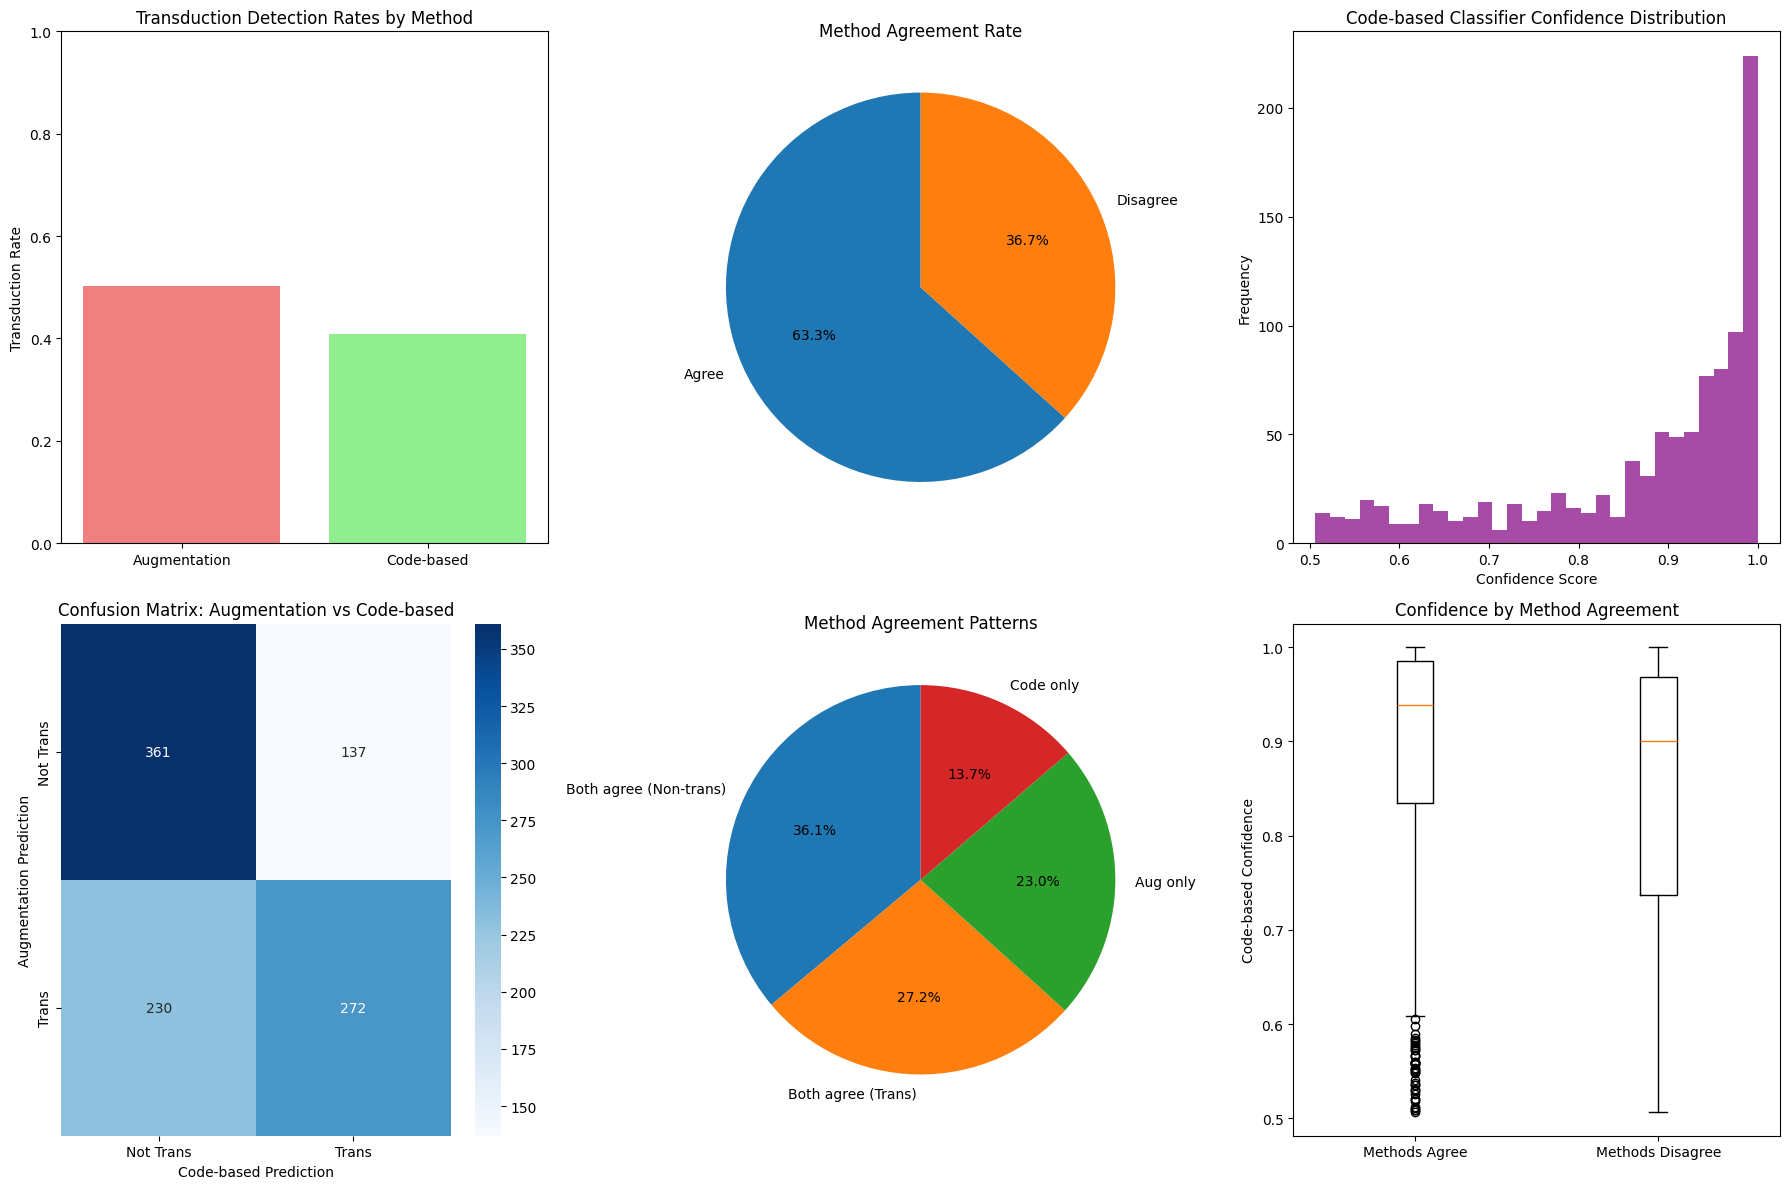


✓ Two-method analysis visualization complete


In [41]:
# Step 5: Analyze differences between both methods
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Filter out error cases for analysis
df_valid = df_analysis[df_analysis['error'].isna()].copy()
print(f"Valid results: {len(df_valid)}/{len(df_analysis)} programs")

# Handle NaN values in boolean columns by filling with False
for col in ['aug_transductive', 'code_transductive']:
    if col in df_valid.columns:
        df_valid[col] = df_valid[col].fillna(False)

# Summary statistics
print("\n" + "="*80)
print("TRANSDUCTION DETECTION COMPARISON - TWO METHODS")
print("="*80)

print(f"\nMETHOD 1 - AUGMENTATION (Invariance Testing):")
print(f"  - Transductive: {df_valid['aug_transductive'].sum():,} ({100*df_valid['aug_transductive'].mean():.1f}%)")

print(f"\nMETHOD 2 - CODE-BASED (ML Classifier):")
print(f"  - Transductive: {df_valid['code_transductive'].sum():,} ({100*df_valid['code_transductive'].mean():.1f}%)")
print(f"  - Average confidence: {df_valid['code_confidence'].mean():.3f}")
print(f"  - Confidence std: {df_valid['code_confidence'].std():.3f}")

# Agreement analysis
agreement = (df_valid['aug_transductive'] == df_valid['code_transductive']).mean()
print(f"\nMETHOD AGREEMENT:")
print(f"  - Methods agree: {(df_valid['aug_transductive'] == df_valid['code_transductive']).sum():,}/{len(df_valid)} ({100*agreement:.1f}%)")

# Disagreement breakdown
disagreement = df_valid[df_valid['aug_transductive'] != df_valid['code_transductive']]
if len(disagreement) > 0:
    aug_yes_code_no = disagreement[(disagreement['aug_transductive'] == True) & (disagreement['code_transductive'] == False)]
    aug_no_code_yes = disagreement[(disagreement['aug_transductive'] == False) & (disagreement['code_transductive'] == True)]
    
    print(f"  - Disagreements: {len(disagreement):,} ({100*(1-agreement):.1f}%)")
    print(f"    • Augmentation=Transductive, Code-based=Non-transductive: {len(aug_yes_code_no):,}")
    print(f"    • Augmentation=Non-transductive, Code-based=Transductive: {len(aug_no_code_yes):,}")

# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Overall transduction rates
method_names = ['Augmentation', 'Code-based']
rates = [
    df_valid['aug_transductive'].mean(), 
    df_valid['code_transductive'].mean()
]
axes[0,0].bar(method_names, rates, color=['lightcoral', 'lightgreen'])
axes[0,0].set_ylabel('Transduction Rate')
axes[0,0].set_title('Transduction Detection Rates by Method')
axes[0,0].set_ylim(0, 1)

# 2. Agreement vs disagreement
agreement_counts = [
    (df_valid['aug_transductive'] == df_valid['code_transductive']).sum(),
    (df_valid['aug_transductive'] != df_valid['code_transductive']).sum()
]
axes[0,1].pie(agreement_counts, labels=['Agree', 'Disagree'], autopct='%1.1f%%', startangle=90)
axes[0,1].set_title('Method Agreement Rate')

# 3. Code-based confidence distribution
axes[0,2].hist(df_valid['code_confidence'], bins=30, alpha=0.7, color='purple')
axes[0,2].set_xlabel('Confidence Score')
axes[0,2].set_ylabel('Frequency')
axes[0,2].set_title('Code-based Classifier Confidence Distribution')

# 4. Confusion matrix
cm = confusion_matrix(df_valid['aug_transductive'], df_valid['code_transductive'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Trans', 'Trans'], 
            yticklabels=['Not Trans', 'Trans'],
            ax=axes[1,0])
axes[1,0].set_title('Confusion Matrix: Augmentation vs Code-based')
axes[1,0].set_xlabel('Code-based Prediction')
axes[1,0].set_ylabel('Augmentation Prediction')

# 5. Method combinations
method_combinations = {
    'Both agree (Non-trans)': (
        (~df_valid['aug_transductive']) & 
        (~df_valid['code_transductive'])
    ),
    'Both agree (Trans)': (
        df_valid['aug_transductive'] & 
        df_valid['code_transductive']
    ),
    'Aug only': (
        df_valid['aug_transductive'] & 
        (~df_valid['code_transductive'])
    ),
    'Code only': (
        (~df_valid['aug_transductive']) & 
        df_valid['code_transductive']
    )
}

combination_counts = {name: mask.sum() for name, mask in method_combinations.items()}

# Pie chart of combinations
axes[1,1].pie(combination_counts.values(), labels=combination_counts.keys(), 
              autopct='%1.1f%%', startangle=90)
axes[1,1].set_title('Method Agreement Patterns')

# 6. Confidence by method agreement
agree_mask = df_valid['aug_transductive'] == df_valid['code_transductive']
agree_conf = df_valid[agree_mask]['code_confidence']
disagree_conf = df_valid[~agree_mask]['code_confidence']

axes[1,2].boxplot([agree_conf, disagree_conf], 
                  labels=['Methods Agree', 'Methods Disagree'])
axes[1,2].set_ylabel('Code-based Confidence')
axes[1,2].set_title('Confidence by Method Agreement')

plt.tight_layout()
plt.show()

print(f"\n✓ Two-method analysis visualization complete")

In [42]:
# Step 6: Detailed Disagreement Analysis
print("\n" + "="*80)
print("DETAILED DISAGREEMENT ANALYSIS")
print("="*80)

# Find cases where methods disagree
disagreement_mask = df_valid['aug_transductive'] != df_valid['code_transductive']
disagreeing_programs = df_valid[disagreement_mask]

print(f"Method Disagreements: {len(disagreeing_programs)} programs ({100*disagreement_mask.mean():.1f}%)")

if len(disagreeing_programs) > 0:
    # Show some example task IDs for manual inspection
    sample_disagreements = disagreeing_programs.sample(min(5, len(disagreeing_programs)), random_state=42)
    print(f"  Sample task IDs: {list(sample_disagreements['task_id'].values)}")
    
    # Analyze patterns in disagreements
    avg_confidence = disagreeing_programs['code_confidence'].mean()
    print(f"  Average code confidence in disagreements: {avg_confidence:.3f}")
    
    # Break down disagreement types
    aug_yes_code_no = disagreeing_programs[
        (disagreeing_programs['aug_transductive'] == True) & 
        (disagreeing_programs['code_transductive'] == False)
    ]
    aug_no_code_yes = disagreeing_programs[
        (disagreeing_programs['aug_transductive'] == False) & 
        (disagreeing_programs['code_transductive'] == True)
    ]
    
    print(f"\nDisagreement Breakdown:")
    print(f"  - Augmentation=Trans, Code-based=Non-trans: {len(aug_yes_code_no):,}")
    print(f"    Average confidence: {aug_yes_code_no['code_confidence'].mean():.3f}")
    print(f"  - Augmentation=Non-trans, Code-based=Trans: {len(aug_no_code_yes):,}")
    print(f"    Average confidence: {aug_no_code_yes['code_confidence'].mean():.3f}")

# Identify high-confidence disagreements for code-based classifier
high_confidence_disagreements = df_valid[
    (df_valid['code_confidence'] > 0.8) & 
    (df_valid['aug_transductive'] != df_valid['code_transductive'])
]

print(f"\nHigh-confidence code classifier disagreements (>0.8): {len(high_confidence_disagreements)}")
if len(high_confidence_disagreements) > 0:
    print(f"  Task IDs: {list(high_confidence_disagreements['task_id'].head(5).values)}")
    print(f"  Average confidence: {high_confidence_disagreements['code_confidence'].mean():.3f}")

# Method consensus analysis
both_agree_trans = (df_valid['aug_transductive'] & df_valid['code_transductive']).sum()
both_agree_non_trans = ((~df_valid['aug_transductive']) & (~df_valid['code_transductive'])).sum()
total_agreement = both_agree_trans + both_agree_non_trans

print(f"\nMethod Consensus Distribution:")
print(f"  Both agree (Transductive): {both_agree_trans:,} programs ({100*both_agree_trans/len(df_valid):.1f}%)")
print(f"  Both agree (Non-transductive): {both_agree_non_trans:,} programs ({100*both_agree_non_trans/len(df_valid):.1f}%)")
print(f"  Methods disagree: {len(disagreeing_programs):,} programs ({100*len(disagreeing_programs)/len(df_valid):.1f}%)")

# Save disagreement cases for further manual analysis
if len(disagreeing_programs) > 0:
    # Select key columns for analysis
    analysis_cols = [
        'task_id', 'aug_transductive', 'code_transductive', 
        'code_confidence', 'aug_reason'
    ]
    
    output_file = '/tmp/method_disagreements.csv'
    disagreeing_programs[analysis_cols].to_csv(output_file, index=False)
    print(f"\n✓ Saved {len(disagreeing_programs)} disagreement cases to: {output_file}")

print(f"\n✓ Disagreement analysis complete")


DETAILED DISAGREEMENT ANALYSIS
Method Disagreements: 367 programs (36.7%)
  Sample task IDs: ['8e5a5113', 'c3e719e8', '05269061', 'a5313dff', '8e5a5113']
  Average code confidence in disagreements: 0.849

Disagreement Breakdown:
  - Augmentation=Trans, Code-based=Non-trans: 230
    Average confidence: 0.857
  - Augmentation=Non-trans, Code-based=Trans: 137
    Average confidence: 0.835

High-confidence code classifier disagreements (>0.8): 255
  Task IDs: ['a5f85a15', '6e02f1e3', '6cdd2623', 'a3df8b1e', 'f9012d9b']
  Average confidence: 0.934

Method Consensus Distribution:
  Both agree (Transductive): 272 programs (27.2%)
  Both agree (Non-transductive): 361 programs (36.1%)
  Methods disagree: 367 programs (36.7%)

✓ Saved 367 disagreement cases to: /tmp/method_disagreements.csv

✓ Disagreement analysis complete


In [43]:
# Step 7: Method Correlation and Statistical Analysis
from scipy.stats import chi2_contingency, fisher_exact
from sklearn.metrics import cohen_kappa_score

print("\n" + "="*80)
print("STATISTICAL CORRELATION ANALYSIS")
print("="*80)

# Cohen's Kappa for inter-rater reliability
kappa = cohen_kappa_score(df_valid['aug_transductive'], df_valid['code_transductive'])

# Interpretation of kappa
if kappa < 0:
    interpretation = "Poor agreement (worse than chance)"
elif kappa < 0.20:
    interpretation = "Slight agreement"
elif kappa < 0.40:
    interpretation = "Fair agreement"
elif kappa < 0.60:
    interpretation = "Moderate agreement"
elif kappa < 0.80:
    interpretation = "Substantial agreement"
else:
    interpretation = "Almost perfect agreement"

print(f"Cohen's Kappa: κ = {kappa:.3f} ({interpretation})")

# Chi-square test for independence
contingency_table = pd.crosstab(df_valid['aug_transductive'], df_valid['code_transductive'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"\nChi-square Test for Independence:")
print(f"  χ² = {chi2:.3f}, p = {p_value:.4f}")
print(f"  {'Significantly dependent' if p_value < 0.05 else 'No significant dependence'} (α = 0.05)")

# Correlation with code confidence
aug_code_correlation = df_valid['aug_transductive'].astype(int).corr(df_valid['code_confidence'])
print(f"\nCorrelation between Augmentation method and Code-based confidence: r = {aug_code_correlation:.3f}")

# Method complementarity analysis
print(f"\nMethod Complementarity (detecting different cases):")

# Cases where only one method detects transduction
only_aug = df_valid['aug_transductive'] & (~df_valid['code_transductive'])
only_code = (~df_valid['aug_transductive']) & df_valid['code_transductive']

print(f"  Only Augmentation method: {only_aug.sum():,} programs ({100*only_aug.mean():.2f}%)")
print(f"  Only Code-based method: {only_code.sum():,} programs ({100*only_code.mean():.2f}%)")

total_unique_detections = only_aug.sum() + only_code.sum()
total_any_transductive = (df_valid['aug_transductive'] | df_valid['code_transductive']).sum()

print(f"  Unique detections: {total_unique_detections:,}/{total_any_transductive:,} ({100*total_unique_detections/total_any_transductive:.1f}% of all transductive)")

# Combined method performance
combined_any = df_valid['aug_transductive'] | df_valid['code_transductive']
combined_both = df_valid['aug_transductive'] & df_valid['code_transductive']

print(f"\nCombined Method Performance:")
print(f"  Either method detects transduction: {combined_any.sum():,} programs ({100*combined_any.mean():.1f}%)")
print(f"  Both methods agree on transduction: {combined_both.sum():,} programs ({100*combined_both.mean():.1f}%)")

# Ensemble approach simulation
print(f"\nEnsemble Approaches:")

# Simple OR combination (either method detects transduction)
ensemble_or = df_valid['aug_transductive'] | df_valid['code_transductive']
print(f"  OR ensemble (either method): {ensemble_or.sum():,} programs ({100*ensemble_or.mean():.1f}%)")

# Simple AND combination (both methods must detect transduction)
ensemble_and = df_valid['aug_transductive'] & df_valid['code_transductive']
print(f"  AND ensemble (both methods): {ensemble_and.sum():,} programs ({100*ensemble_and.mean():.1f}%)")

# Weighted ensemble (using code confidence)
# Higher confidence code predictions get more weight
weighted_ensemble = (
    df_valid['aug_transductive'].astype(int) * 1.0 +
    df_valid['code_transductive'].astype(int) * df_valid['code_confidence'] * 1.5  # Weight by confidence
) >= 1.0

print(f"  Weighted ensemble (confidence-weighted): {weighted_ensemble.sum():,} programs ({100*weighted_ensemble.mean():.1f}%)")

# Confidence-based threshold ensemble
high_confidence_threshold = 0.8
confidence_ensemble = (
    df_valid['aug_transductive'] | 
    ((df_valid['code_transductive']) & (df_valid['code_confidence'] > high_confidence_threshold))
)

print(f"  Confidence ensemble (Aug OR high-conf Code): {confidence_ensemble.sum():,} programs ({100*confidence_ensemble.mean():.1f}%)")

print(f"\n✓ Statistical analysis complete")


STATISTICAL CORRELATION ANALYSIS
Cohen's Kappa: κ = 0.267 (Fair agreement)

Chi-square Test for Independence:
  χ² = 72.483, p = 0.0000
  Significantly dependent (α = 0.05)

Correlation between Augmentation method and Code-based confidence: r = -0.017

Method Complementarity (detecting different cases):
  Only Augmentation method: 230 programs (23.00%)
  Only Code-based method: 137 programs (13.70%)
  Unique detections: 367/639 (57.4% of all transductive)

Combined Method Performance:
  Either method detects transduction: 639 programs (63.9%)
  Both methods agree on transduction: 272 programs (27.2%)

Ensemble Approaches:
  OR ensemble (either method): 639 programs (63.9%)
  AND ensemble (both methods): 272 programs (27.2%)
  Weighted ensemble (confidence-weighted): 613 programs (61.3%)
  Confidence ensemble (Aug OR high-conf Code): 587 programs (58.7%)

✓ Statistical analysis complete


In [46]:
# Step 8: Sample Program Analysis for Disagreement Types
print("\n" + "="*80)
print("SAMPLE PROGRAM ANALYSIS")
print("="*80)

def analyze_sample_programs(df_subset, title, max_samples=3):
    """Analyze and display sample programs from a subset"""
    print(f"\n{title} ({len(df_subset)} programs)")
    print("-" * 60)
    
    if len(df_subset) == 0:
        print("  No programs in this category")
        return
    
    # Sample up to max_samples programs
    sample_programs = df_subset.sample(min(max_samples, len(df_subset)), random_state=42)
    
    for idx, (_, row) in enumerate(sample_programs.iterrows()):
        print(f"\nSample {idx+1}:")
        print(f"  Task ID: {row['task_id']}")
        print(f"  Augmentation: {row['aug_transductive']} ({row['aug_reason']})")
        print(f"  Code-based: {row['code_transductive']} (confidence: {row['code_confidence']:.3f})")
        
        # Show a snippet of the code
        code_lines = row['code'].split('\n')
        print(f"  Code preview:")
        for i, line in enumerate(code_lines):
            print(f"    {i+1:2d}: {line}")

# Analyze different agreement/disagreement patterns
analysis_patterns = {
    "Both methods agree (Transductive)": df_valid[
        df_valid['aug_transductive'] & 
        df_valid['code_transductive']
    ],
    
    "Both methods agree (Non-transductive)": df_valid[
        (~df_valid['aug_transductive']) & 
        (~df_valid['code_transductive'])
    ],
    
    "Only Augmentation detects transduction": df_valid[
        df_valid['aug_transductive'] & 
        (~df_valid['code_transductive'])
    ],
    
    "Only Code-based detects transduction": df_valid[
        (~df_valid['aug_transductive']) & 
        df_valid['code_transductive']
    ],
    
    "High confidence Code-based disagreements": df_valid[
        (df_valid['code_confidence'] > 0.9) &
        (df_valid['code_transductive'] != df_valid['aug_transductive'])
    ],
    
    "Low confidence Code-based disagreements": df_valid[
        (df_valid['code_confidence'] < 0.6) &
        (df_valid['code_transductive'] != df_valid['aug_transductive'])
    ]
}

# Analyze each pattern
for pattern_name, pattern_df in analysis_patterns.items():
    analyze_sample_programs(pattern_df, pattern_name, max_samples=10)

# Summary of interesting patterns
print(f"\n" + "="*60)
print("PATTERN SUMMARY")
print("="*60)

for pattern_name, pattern_df in analysis_patterns.items():
    if len(pattern_df) > 0:
        avg_confidence = pattern_df['code_confidence'].mean()
        unique_tasks = pattern_df['task_id'].nunique()
        print(f"{pattern_name}: {len(pattern_df)} programs, {unique_tasks} unique tasks, avg confidence: {avg_confidence:.3f}")

print(f"\n✓ Sample program analysis complete")


SAMPLE PROGRAM ANALYSIS

Both methods agree (Transductive) (272 programs)
------------------------------------------------------------

Sample 1:
  Task ID: 505fff84
  Augmentation: True (Program is not invariant to any augmentation (likely memorizing specific values))
  Code-based: True (confidence: 1.000)
  Code preview:
     1: import numpy as np
     2: 
     3: def transform(grid_lst: list[list[int]]) -> list[list[int]]:
     4:     grid = np.array(grid_lst)
     5:     rows, cols = grid.shape
     6:     if rows == 14 and cols == 11:
     7:         output_shape = (5, 5)
     8:     elif rows == 4 and cols == 11:
     9:         output_shape = (1, 7)
    10:     elif rows == 5 and cols == 10:
    11:         output_shape = (2, 3)
    12:     elif rows == 6 and cols == 12:
    13:         output_shape = (3, 4)
    14:     elif rows == 8 and cols == 12:
    15:         output_shape = (3, 6)
    16:     elif rows == 9 and cols == 14:
    17:         output_shape = (5, 5)
    18:   

In [45]:
# Step 9: Summary and Recommendations
print("\n" + "="*80)
print("FINAL SUMMARY AND RECOMMENDATIONS")
print("="*80)

# Create summary DataFrame
summary_data = {
    'Method': ['Augmentation (Invariance)', 'Code-based (ML)'],
    'Transduction_Rate': [
        df_valid['aug_transductive'].mean(),
        df_valid['code_transductive'].mean()
    ],
    'Sample_Size': [len(df_valid)] * 2
}

# Add agreement score
method_agreement = (df_valid['aug_transductive'] == df_valid['code_transductive']).mean()
summary_data['Agreement_Rate'] = [method_agreement, method_agreement]

summary_df = pd.DataFrame(summary_data)
print("Method Comparison Summary:")
print(summary_df.round(3))

# Key insights
print(f"\nKEY INSIGHTS:")
print(f"1. DETECTION RATES:")
print(f"   - Augmentation method: {100*df_valid['aug_transductive'].mean():.1f}% (focuses on pattern invariance)")  
print(f"   - Code-based method: {100*df_valid['code_transductive'].mean():.1f}% (ML on program features)")

print(f"\n2. METHOD AGREEMENT:")
print(f"   - Overall agreement: {100*method_agreement:.1f}%")
print(f"   - Cohen's Kappa: κ = {kappa:.3f} ({interpretation})")

print(f"\n3. METHOD COMPLEMENTARITY:")
any_method = (df_valid['aug_transductive'] | df_valid['code_transductive']).sum()
both_methods = (df_valid['aug_transductive'] & df_valid['code_transductive']).sum()
print(f"   - Either method detects: {any_method:,} programs ({100*any_method/len(df_valid):.1f}%)")
print(f"   - Both methods agree: {both_methods:,} programs ({100*both_methods/len(df_valid):.1f}%)")
print(f"   - Complementary detections: {any_method - both_methods:,} programs ({100*(any_method-both_methods)/len(df_valid):.1f}%)")

# Method-specific strengths
only_aug = (df_valid['aug_transductive'] & (~df_valid['code_transductive'])).sum()
only_code = ((~df_valid['aug_transductive']) & df_valid['code_transductive']).sum()

print(f"\n4. UNIQUE DETECTIONS:")
print(f"   - Only Augmentation: {only_aug:,} programs ({100*only_aug/len(df_valid):.1f}%)")
print(f"   - Only Code-based: {only_code:,} programs ({100*only_code/len(df_valid):.1f}%)")

# Recommendations
print(f"\nRECOMMENDATIONS:")
print(f"1. ENSEMBLE APPROACH:")
print(f"   - Use OR combination for maximum coverage ({100*(df_valid['aug_transductive'] | df_valid['code_transductive']).mean():.1f}% detection)")
print(f"   - Use AND combination for high precision ({100*(df_valid['aug_transductive'] & df_valid['code_transductive']).mean():.1f}% detection)")
print(f"   - Weight code-based predictions by confidence scores")

print(f"\n2. METHOD-SPECIFIC STRENGTHS:")
print(f"   - Augmentation method: Tests actual program behavior, catches subtle invariance violations")
print(f"   - Code-based method: Fast execution, no runtime needed, learns from program structure")

print(f"\n3. PRACTICAL DEPLOYMENT:")
high_confidence_code = (df_valid['code_confidence'] > 0.9).sum()
print(f"   - Use code-based for fast screening ({high_confidence_code:,} high-confidence predictions)")
print(f"   - Apply augmentation testing for uncertain or critical cases")
print(f"   - Consider confidence thresholds: >0.8 for high confidence, <0.6 for uncertain")

print(f"\n4. FURTHER INVESTIGATION:")
print(f"   - Analyze the {(df_valid['aug_transductive'] != df_valid['code_transductive']).sum():,} disagreement cases")
print(f"   - Use augmentation method results to improve code-based classifier training")
print(f"   - Investigate task-specific patterns in method performance")

# Save comprehensive results
output_data = df_valid[[
    'task_id', 'aug_transductive', 'code_transductive',
    'code_confidence', 'aug_reason'
]].copy()

# Add ensemble predictions
output_data['ensemble_or'] = (
    output_data['aug_transductive'] | 
    output_data['code_transductive']
)

output_data['ensemble_and'] = (
    output_data['aug_transductive'] & 
    output_data['code_transductive']
)

output_data['weighted_ensemble'] = (
    output_data['aug_transductive'].astype(int) * 1.0 +
    output_data['code_transductive'].astype(int) * output_data['code_confidence'] * 1.5
) >= 1.0

final_output_file = '/tmp/two_method_transduction_analysis.csv'
output_data.to_csv(final_output_file, index=False)

print(f"\n✓ Saved complete analysis to: {final_output_file}")
print(f"✓ Analysis complete for {len(df_valid):,} programs")
print(f"✓ Two-method transduction detection comparison finished")


FINAL SUMMARY AND RECOMMENDATIONS
Method Comparison Summary:
                      Method  Transduction_Rate  Sample_Size  Agreement_Rate
0  Augmentation (Invariance)              0.502         1000           0.633
1            Code-based (ML)              0.409         1000           0.633

KEY INSIGHTS:
1. DETECTION RATES:
   - Augmentation method: 50.2% (focuses on pattern invariance)
   - Code-based method: 40.9% (ML on program features)

2. METHOD AGREEMENT:
   - Overall agreement: 63.3%
   - Cohen's Kappa: κ = 0.267 (Fair agreement)

3. METHOD COMPLEMENTARITY:
   - Either method detects: 639 programs (63.9%)
   - Both methods agree: 272 programs (27.2%)
   - Complementary detections: 367 programs (36.7%)

4. UNIQUE DETECTIONS:
   - Only Augmentation: 230 programs (23.0%)
   - Only Code-based: 137 programs (13.7%)

RECOMMENDATIONS:
1. ENSEMBLE APPROACH:
   - Use OR combination for maximum coverage (63.9% detection)
   - Use AND combination for high precision (27.2% detection)
   